## Create and test ion channel model

In [1]:
from experiments.ikr_markov import (toyoda_iv,
                                    toyoda_taua,
                                    toyoda_trec,
                                    toyoda_inact)
from experiments.ikr_markov import toyoda_deact_single_exp as toyoda_deact

In [2]:
from ionchannelABC.experiment import setup
from ionchannelABC import plot_sim_results

In [3]:
modelfile = 'models/ikr_simple.mmt'
#modelfile = 'models/ikr_markov.mmt'
#modelfile = 'models/Korhonen2009_iKr.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                toyoda_iv,
                                                toyoda_taua,
                                                toyoda_deact,
                                                toyoda_trec,
                                                toyoda_inact)

In [5]:
assert len(observations)==len(summary_statistics(model({})))

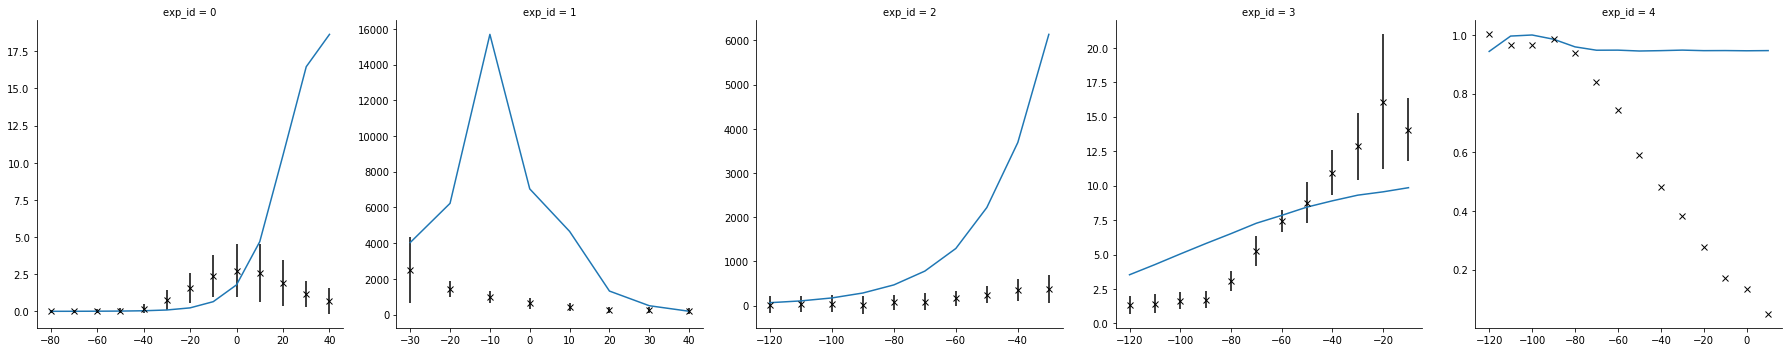

In [6]:
g = plot_sim_results(modelfile, toyoda_iv, toyoda_taua, toyoda_deact, toyoda_trec, toyoda_inact)

## Set limits and generate uniform initial priors

In [7]:
from pyabc import Distribution, RV
limits = {'log_ikr.p_1': (-7., 3.),
          'ikr.p_2': (1e-7, 0.4),
          'log_ikr.p_3': (-7., 3.),
          'ikr.p_4': (1e-7, 0.4),
          'log_ikr.p_5': (-7., 3.),
          'ikr.p_6': (1e-7, 0.4),
          'log_ikr.p_7': (-7., 3.),
          'ikr.p_8': (1e-7, 0.4),
          'ikr.g_Kr': (0., 10.)
         }
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [8]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ikr.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ikr.db


In [9]:
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [10]:
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [14]:
from pyabc import ABCSMC
from pyabc.populationstrategy import ConstantPopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=2),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.6112803623200265, '1': 1.6112803623200265, '2': 1.6112803623200265, '3': 1.2100319803931816, '4': 0.7117835178783347, '5': 0.31843906758003204, '6': 0.2240799963691058, '7': 0.15513458342021064, '8': 0.1247455649889869, '9': 0.11203880987253963, '10': 0.14235670357566746, '11': 0.246945302121056, '12': 0.2574598876147306, '13': 0.17612304832869144, '14': 0.7422328465280542, '15': 0.9446599864902547, '16': 1.0938168264624035, '17': 1.4844656930561084, '18': 2.078251970278555, '19': 2.078251970278555, '20': 2.078251970278555, '21': 0.2113258677624603, '22': 0.21132586776245807, '23': 0.2113258677624603, '24': 0.19513417845346573, '25': 0.23053731028631988, '26': 0.2113258677624603, '27': 0.2306269089300404, '28': 0.2113258677624603, '29': 0.15849440082184607, '30': 0.12679552065747565, '31': 1.745553725846695, '32': 1.745553725846695, '33': 1.745553725846695, '34': 1.745553725846695, '35': 1.745553725846695, '36': 1.2957319713203896, '37': 1.7455537

In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 19512
DEBUG:Epsilon:new eps, t=1, eps=8.358026730806767
INFO:ABC:t:1 eps:8.358026730806767
DEBUG:ABC:now submitting population 1


In [18]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc_continued = ABCSMC(models=model,
     parameter_priors=prior,
     distance_function=IonChannelDistance(
         exp_id=list(observations.exp_id),
         variance=list(observations.variance),
         delta=0.05),
     population_size=ConstantPopulationSize(2000),
     summary_statistics=summary_statistics,
     transitions=EfficientMultivariateNormalTransition(),
     eps=MedianEpsilon(),
     sampler=MulticoreEvalParallelSampler(n_procs=4),
     acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.6112803623200265, '1': 1.6112803623200265, '2': 1.6112803623200265, '3': 1.2100319803931816, '4': 0.7117835178783347, '5': 0.31843906758003204, '6': 0.2240799963691058, '7': 0.15513458342021064, '8': 0.1247455649889869, '9': 0.11203880987253963, '10': 0.14235670357566746, '11': 0.246945302121056, '12': 0.2574598876147306, '13': 0.17612304832869144, '14': 0.7422328465280542, '15': 0.9446599864902547, '16': 1.0938168264624035, '17': 1.4844656930561084, '18': 2.078251970278555, '19': 2.078251970278555, '20': 2.078251970278555, '21': 0.2113258677624603, '22': 0.21132586776245807, '23': 0.2113258677624603, '24': 0.19513417845346573, '25': 0.23053731028631988, '26': 0.2113258677624603, '27': 0.2306269089300404, '28': 0.2113258677624603, '29': 0.15849440082184607, '30': 0.12679552065747565, '31': 1.745553725846695, '32': 1.745553725846695, '33': 1.745553725846695, '34': 1.745553725846695, '35': 1.745553725846695, '36': 1.2957319713203896, '37': 1.7455537

In [20]:
abc_continued.load(db_path, 2)

2

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:Epsilon:initial epsilon is 1.20969674342258
INFO:ABC:t:15 eps:1.20969674342258
DEBUG:ABC:now submitting population 15


# Results analysis

In [22]:
from pyabc import History

In [8]:
db_path = 'sqlite:////scratch/cph211/tmp/hl1_ikr.db'

In [23]:
db_path = 'sqlite:////storage/hhecm/cellrotor/chouston/abc-hl1-results/ikr/3/hl1_ikr.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-08-20 15:44:41.138706, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-08-20 15:44:46.999463, end_time=2019-08-31 03:08:06.552516)>]

In [24]:
history.id = 2

In [25]:
df, w = history.get_distribution(m=0)

In [26]:
df.describe()

name,ikr.g_Kr,ikr.p_2,ikr.p_4,ikr.p_6,ikr.p_8,log_ikr.p_1,log_ikr.p_3,log_ikr.p_5,log_ikr.p_7
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.491882,0.067495,0.028539,0.032826,0.035647,-3.142759,-3.162373,-1.164527,-1.863523
std,0.019945,0.000922,0.000280,0.000913,0.000169,0.008324,0.008093,0.008835,0.004367
min,0.445609,0.064394,0.027521,0.030057,0.035031,-3.174164,-3.184778,-1.188188,-1.875112
25%,0.476055,0.066834,0.028358,0.032079,0.035530,-3.148024,-3.167951,-1.171809,-1.866504
50%,0.489254,0.067460,0.028552,0.032765,0.035641,-3.142253,-3.162963,-1.166180,-1.863696
75%,0.507213,0.068103,0.028727,0.033630,0.035755,-3.136835,-3.157950,-1.156723,-1.860664
max,0.547431,0.070259,0.029368,0.034850,0.036245,-3.121109,-3.131140,-1.143720,-1.849191


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


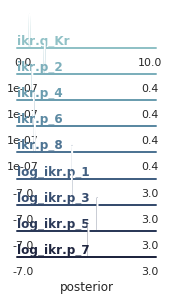

In [27]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits)#, aspect=12,height=0.6)

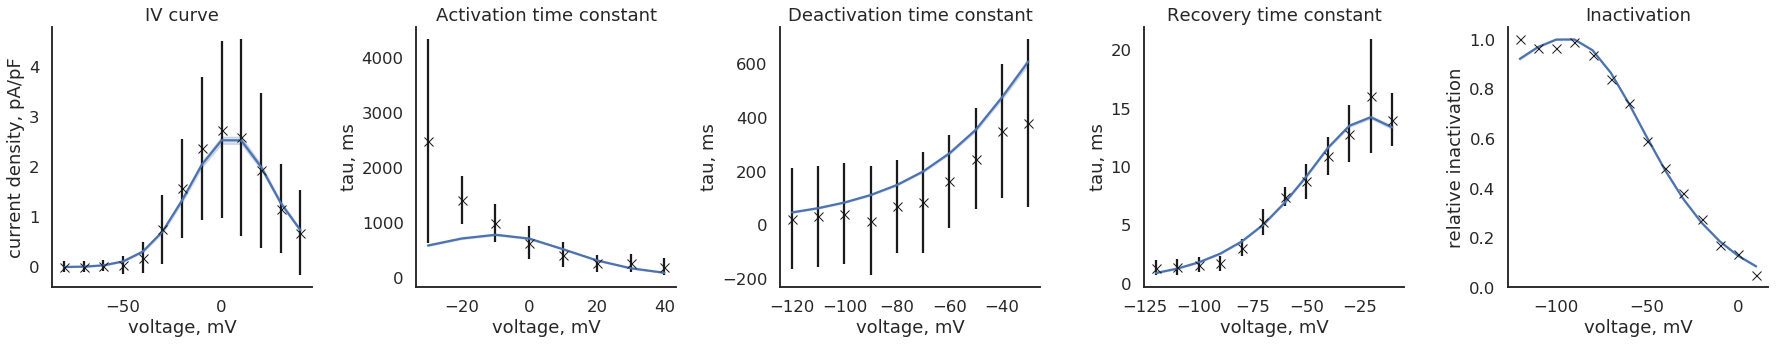

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile, toyoda_iv, toyoda_taua, toyoda_deact, toyoda_trec, toyoda_inact, 
                     df=df, w=w)

xlabels = ["voltage, mV"]*5
ylabels = ["current density, pA/pF", 
           "tau, ms", 
           "tau, ms",
           "tau, ms",
           "relative inactivation"]
titles = ["IV curve", 
          "Activation time constant", 
          "Deactivation time constant",
          "Recovery time constant",
          "Inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax, t in zip(g.axes.flatten(), titles):
    ax.set_title(t)

plt.tight_layout()

In [29]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ikr/calibrated.pdf')

In [30]:
from ionchannelABC.visualization import plot_experiment_traces

In [31]:
def split_iv(data):
    out = []
    for d in data.split_periodic(11000, adjust=True):
        d = d.trim(4900, 6000, adjust=True)
        out.append(d)
    return out

In [32]:
from experiments.ikr_markov import characteristic_time, tsplit

def split_taua(data):
    out = []
    # Only show first train
    for d in data.split_periodic(characteristic_time, adjust=True):
        trace, d = d.split(tsplit[0])
        trace = trace.trim(tsplit[0]-5100, tsplit[0]-4000, adjust=True)
        out.append(trace)
    return out

In [33]:
def split_deact(data):
    out = []
    for d in data.split_periodic(11000, adjust=True):
        d = d.trim(4900, 6000, adjust=True)
        out.append(d)
    return out

In [34]:
def split_trec(data):
    out = []
    for d in data.split_periodic(7000, adjust=True):
        d = d.trim(5900, 7000, adjust=True)
        out.append(d)
    return out

In [37]:
def split_inact(data):
    out = []
    for d in data.split_periodic(11010, adjust=True):
        d = d.trim(5900, 6200, adjust=True)
        out.append(d)
    return out

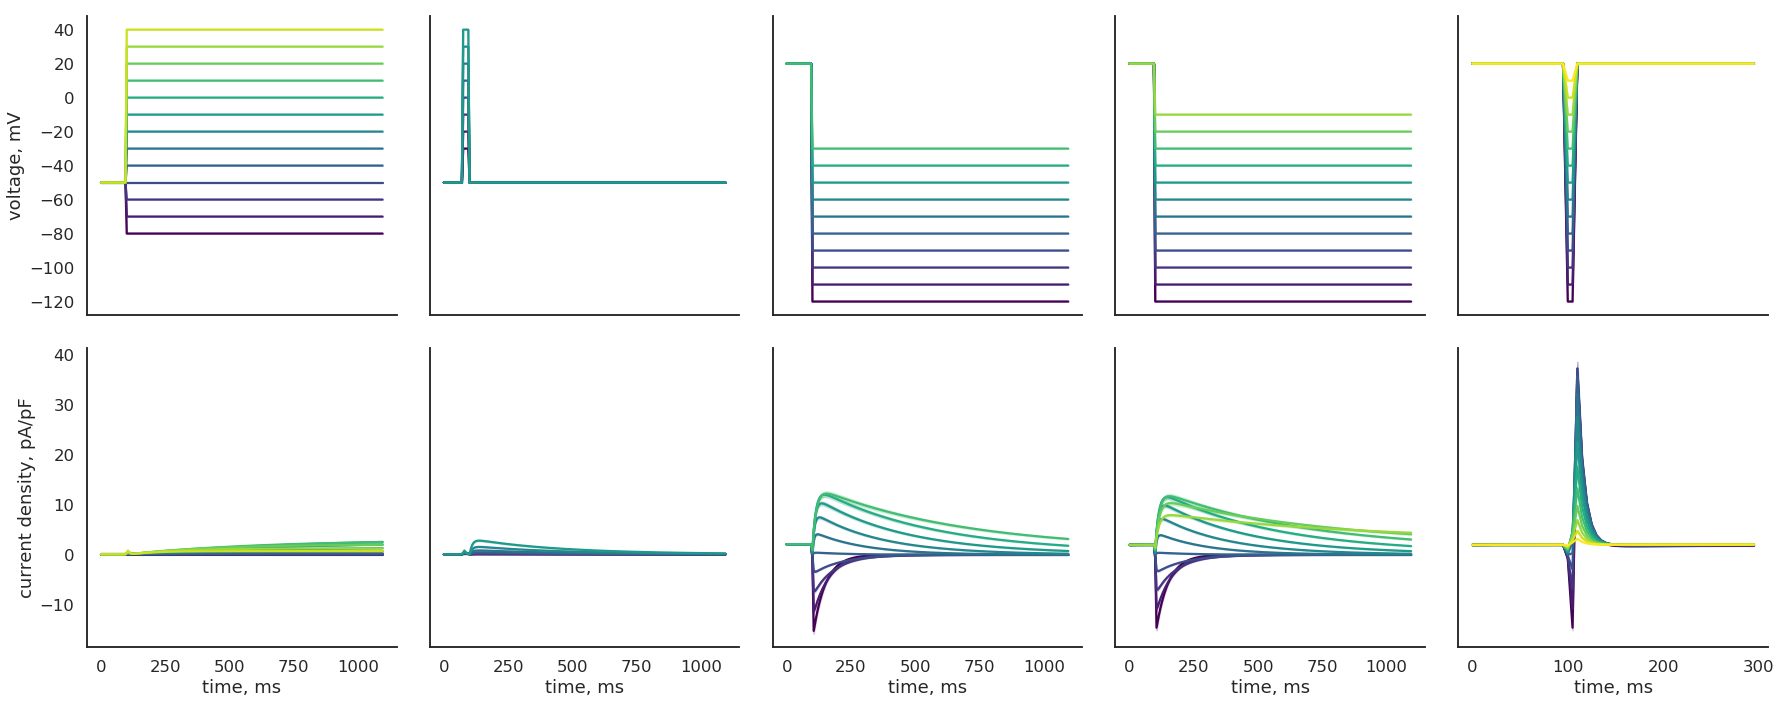

In [38]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, 'ikr.i_Kr', [split_iv, split_taua, split_deact, split_trec, split_inact],
                           toyoda_iv, toyoda_taua, toyoda_deact, toyoda_trec, toyoda_inact,
                           df=df, w=w, 
                           log_interval=5, n_samples=100)

xlabel = "time, ms"
ylabels = ["voltage, mV", "current density, pA/pF"]
for ax in g.axes[1,:]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
    
plt.tight_layout()

In [39]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ikr/protocol.pdf')

> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) import matplotlib.pyplot as plt
(Pdb) plt.plot(intervals, peak_tail)
(Pdb) plt.show()


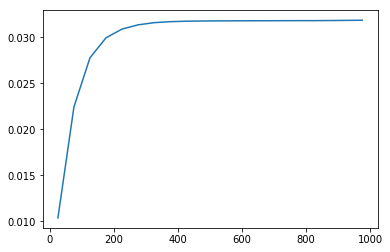

(Pdb) plt.plot(intervals,fit)
(Pdb) plt.show()


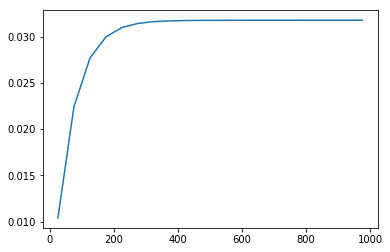

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail)
(Pdb) plt.plot(intervals,fit)
(Pdb) plt.show()


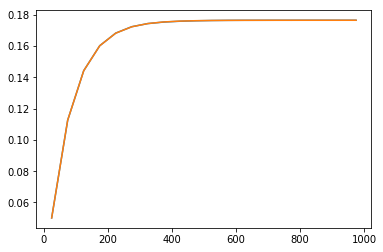

(Pdb) popt
array([ 7.32602381e+01,  1.77708984e-01, -1.23896822e-03])
(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail)
(Pdb) plt.plot(intervals,fit)
(Pdb) plt.show()


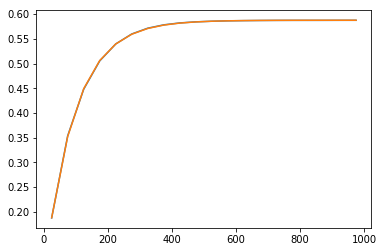

(Pdb) popt
array([9.43678466e+01, 5.20728279e-01, 6.68194518e-02])
(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail)
(Pdb) plt.plot(intervals,fit)
(Pdb) plt.show()


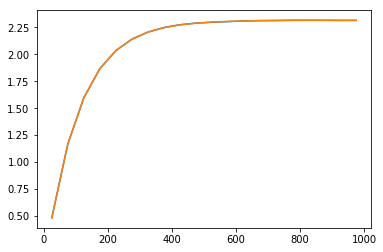

(Pdb) popt
array([ 1.06715999e+02,  2.31659484e+00, -1.36942342e-03])
(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


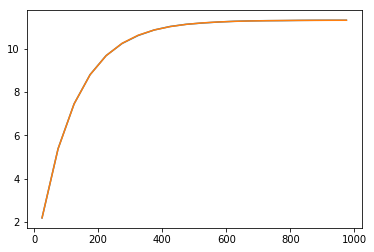

(Pdb) popt
array([1.16414575e+02, 1.13160597e+01, 4.96043069e-03])
(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


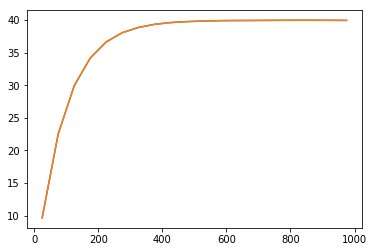

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


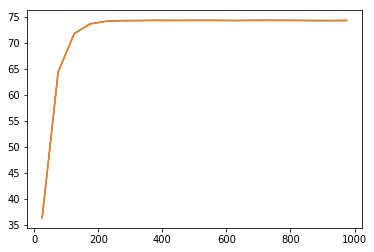

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


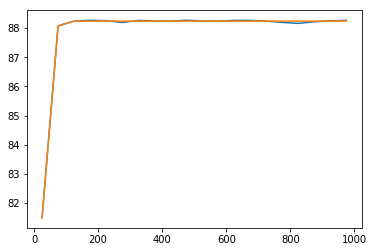

(Pdb) popt
array([13.44112139, 43.40767222, 44.83399617])
(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()
*** NameError: name 'plt' is not defined
(Pdb) import matplotlib.pyplot as plt
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


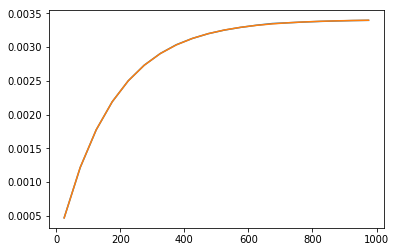

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


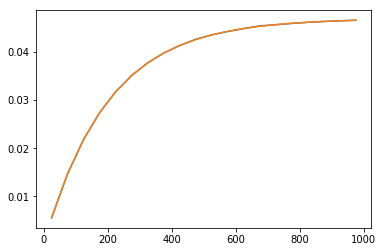

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


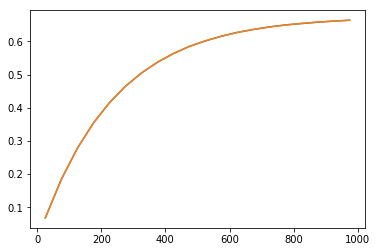

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


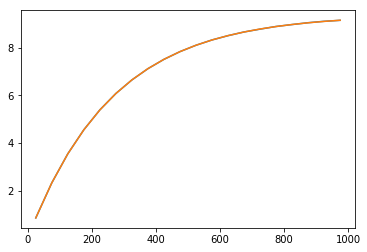

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


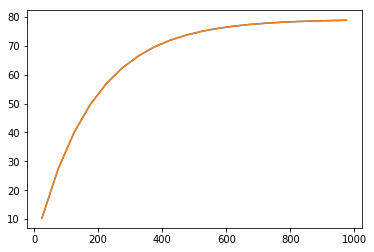

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


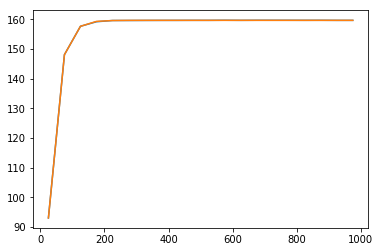

(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(112)toyoda_taua_sum_stats()
-> taua = popt[0]
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


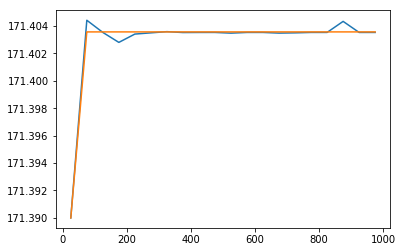

(Pdb) popt
array([  4.87839143,   2.28514246, 169.11843187])
(Pdb) c
> /scratch/cph211/ion-channel-ABC/docs/examples/hl1/experiments/ikr_markov.py(111)toyoda_taua_sum_stats()
-> import pdb;pdb.set_trace()
(Pdb) plt.plot(intervals,peak_tail);plt.plot(intervals,fit);plt.show()


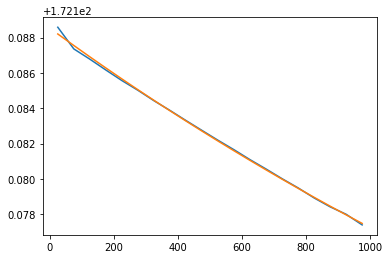

(Pdb) popt
array([ 3.04451727e+03, -4.03827702e-02,  1.72188537e+02])
(Pdb) q


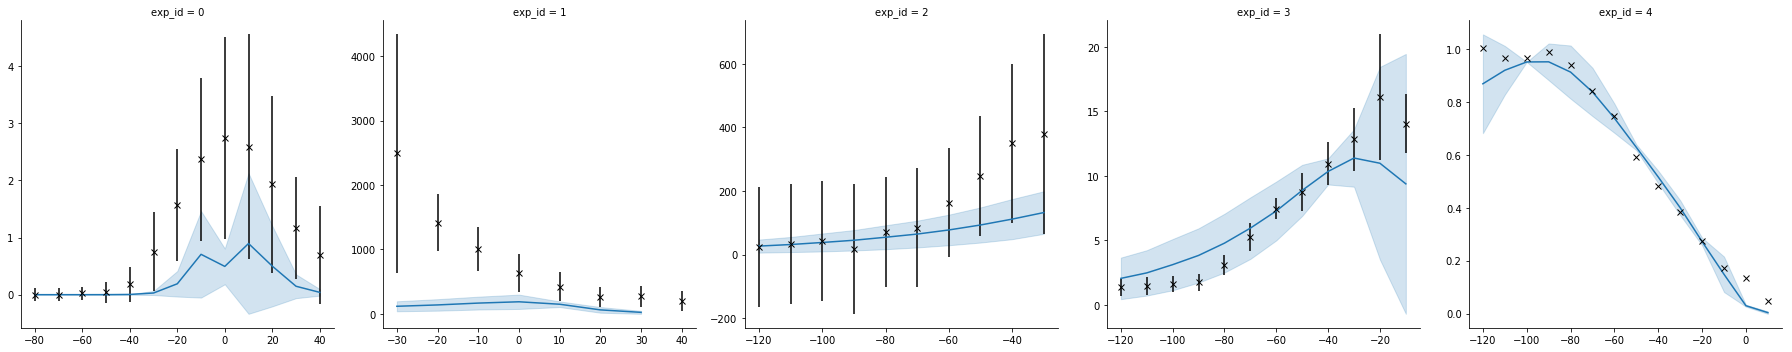

In [9]:
g = plot_sim_results(modelfile, toyoda_iv, toyoda_taua, toyoda_deact, toyoda_trec, toyoda_inact, df=df, w=w, n_samples=2)

# Samples for quantitative analysis

In [14]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [15]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

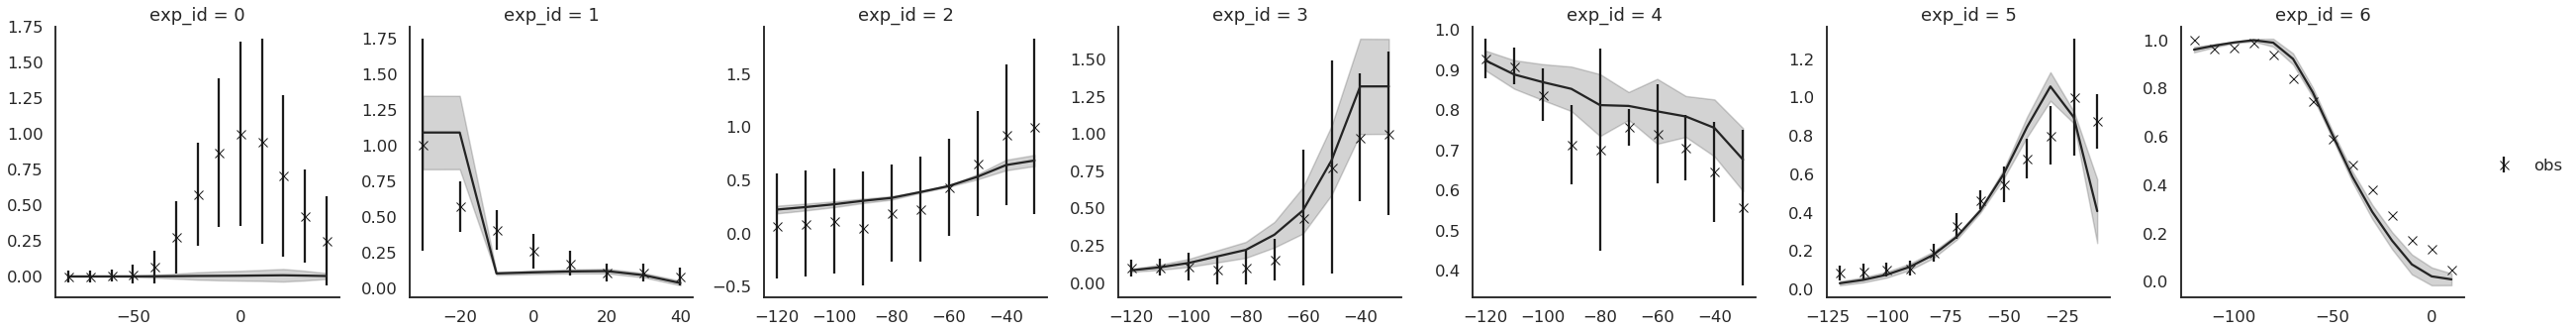

In [16]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [19]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp_id',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

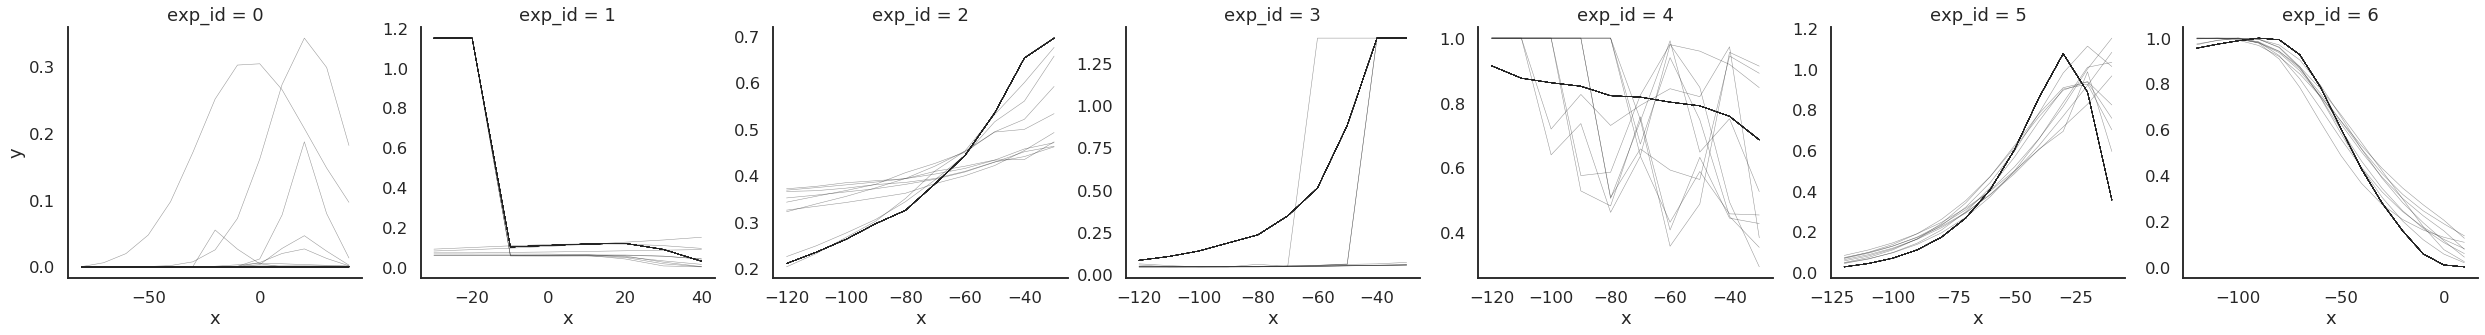

In [20]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
